# Using PEtab

This notebook illustrates how to run model simulations based on [PEtab](https://github.com/petab-dev/petab) problems with AMICI.

PEtab is a format for specifying parameter estimation problems in systems biology. It is based on [SBML](http://sbml.org/) and [TSV](https://en.wikipedia.org/wiki/Tab-separated_values) files. (AMICI also supports PySB-based PEtab problems, that will be covered by PEtab v2). The Python package [pyPESTO](https://pypesto.readthedocs.io/) provides a convenient interface for parameter estimation with PEtab problems and uses AMICI as a backend. However, AMICI can also be used directly to simulate PEtab problems. This is illustrated in this notebook.

In [34]:
import petab

from amici import runAmiciSimulation
from amici.petab.petab_import import import_petab_problem
from amici.petab.petab_problem import AmiciPetabProblem
from amici.petab.simulations import simulate_petab
from amici.plotting import plot_state_trajectories

## Importing a PEtab problem

We use the [Boehm_JProteomeRes2014](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab/tree/master/Benchmark-Models/Boehm_JProteomeRes2014) example model from the [benchmark collection](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab):

In [2]:
model_name = "Boehm_JProteomeRes2014"
# local path or URL to the yaml file for the PEtab problem
petab_yaml = f"https://raw.githubusercontent.com/Benchmarking-Initiative/Benchmark-Models-PEtab/master/Benchmark-Models/{model_name}/{model_name}.yaml"
# load the problem using the PEtab library
petab_problem = petab.Problem.from_yaml(petab_yaml)


Next, we import the model to amici using `import_petab_problem`. `import_petab_problem` has many options to choose between faster importer or more flexible or faster model simulations. We import the model with default settings, and we obtain an AMICI model instance:

In [7]:
amici_model = import_petab_problem(petab_problem, verbose=False)

That's it. Now, we can use the model to perform simulations.

## Simulating a PEtab problem

For simple simulations, a function `simulate_petab` is available. This function will simulate the model for all conditions specified in the PEtab problem and compute the objective value (and if requested, the gradient). `simulate_petab` is mostly useful for running individual simulations. If large numbers of model simulations are required, there are more efficient means. In particular, for parameter estimation, consider using the optimized objective function provided by [pyPESTO](https://github.com/icb-dcm/pypesto).

We use the `simulate_petab` function to simulate the model at the nominal parameters (i.e., the parameters specified in the PEtab problem in the `nominalValue` column of the parameter table):

In [9]:
simulate_petab(petab_problem, amici_model)

{'llh': -138.22199760826,
 'sllh': None,
 'rdatas': [<ReturnDataView(id='model1_data1', status=AMICI_SUCCESS)>],
 'edatas': [<Swig Object of type 'amici::ExpData *' at 0x739143f821c0
    condition 'model1_data1' starting at t=0.0 with custom parameter scales, constants, parameters
    16x3 time-resolved datapoints
      (48/48 measurements & 0/48 sigmas set)
    10x0 event-resolved datapoints
      (0/0 measurements & 0/0 sigmas set)
  >]}

 Parameters can also be directly specified, both scaled and unscaled:

In [15]:
parameters = {
    x_id: x_val
    for x_id, x_val in zip(petab_problem.x_ids, petab_problem.x_nominal_scaled)
    # Fixed parameters cannot be changed in `simulate_petab`, unless we explicitly pass
    #  a `parameter_mapping` that was generated with `fill_fixed_parameters=False`
    if x_id not in amici_model.getFixedParameterIds()
}
simulate_petab(
    petab_problem,
    amici_model,
    problem_parameters=parameters,
    scaled_parameters=True,
)

{'llh': -138.22199760826,
 'sllh': None,
 'rdatas': [<ReturnDataView(id='model1_data1', status=AMICI_SUCCESS)>],
 'edatas': [<Swig Object of type 'amici::ExpData *' at 0x739143e93e10
    condition 'model1_data1' starting at t=0.0 with custom parameter scales, constants, parameters
    16x3 time-resolved datapoints
      (48/48 measurements & 0/48 sigmas set)
    10x0 event-resolved datapoints
      (0/0 measurements & 0/0 sigmas set)
  >]}

## Working with PEtab-defined simulation conditions

`simulate_petab` is convenient for quickly simulating PEtab-based problems, but for certain applications it may be too inflexible.
For example, it is not easily possible to obtain model outputs for time points other than the measurement timepoints specified in the PEtab problem. In such a case, the `AmiciPetabProblem` class can be used to easily generate AMICI `ExpData` objects representing PEtab-defined simulation conditions:

In [30]:
app = AmiciPetabProblem(petab_problem)

# ExpData for all conditions:
app.get_edatas()

# ExpData for a single condition:
edata = app.get_edata("model1_data1")

In [39]:
rdata = runAmiciSimulation(amici_model, solver=amici_model.getSolver(), edata=edata)
rdata

<ReturnDataView(id='model1_data1', status=AMICI_SUCCESS)>

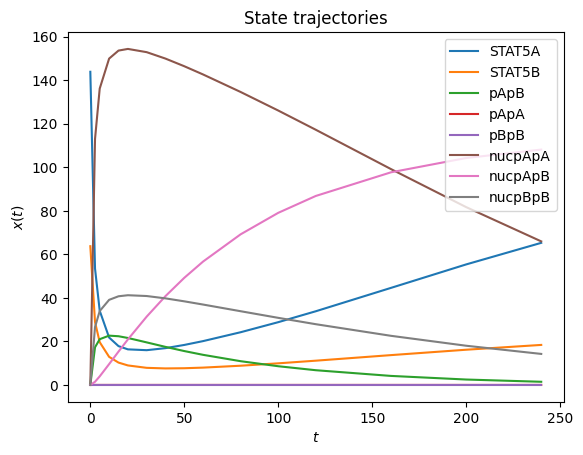

In [40]:
plot_state_trajectories(rdata)

For further information, check out the [AMICI documentation](https://amici.readthedocs.io/en/latest/).